# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [35]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score,classification_report
from sklearn.impute import KNNImputer

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

**DATA EXTRACTION**

In [37]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in sa

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)
print(data.columns)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)
Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)


# 2. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

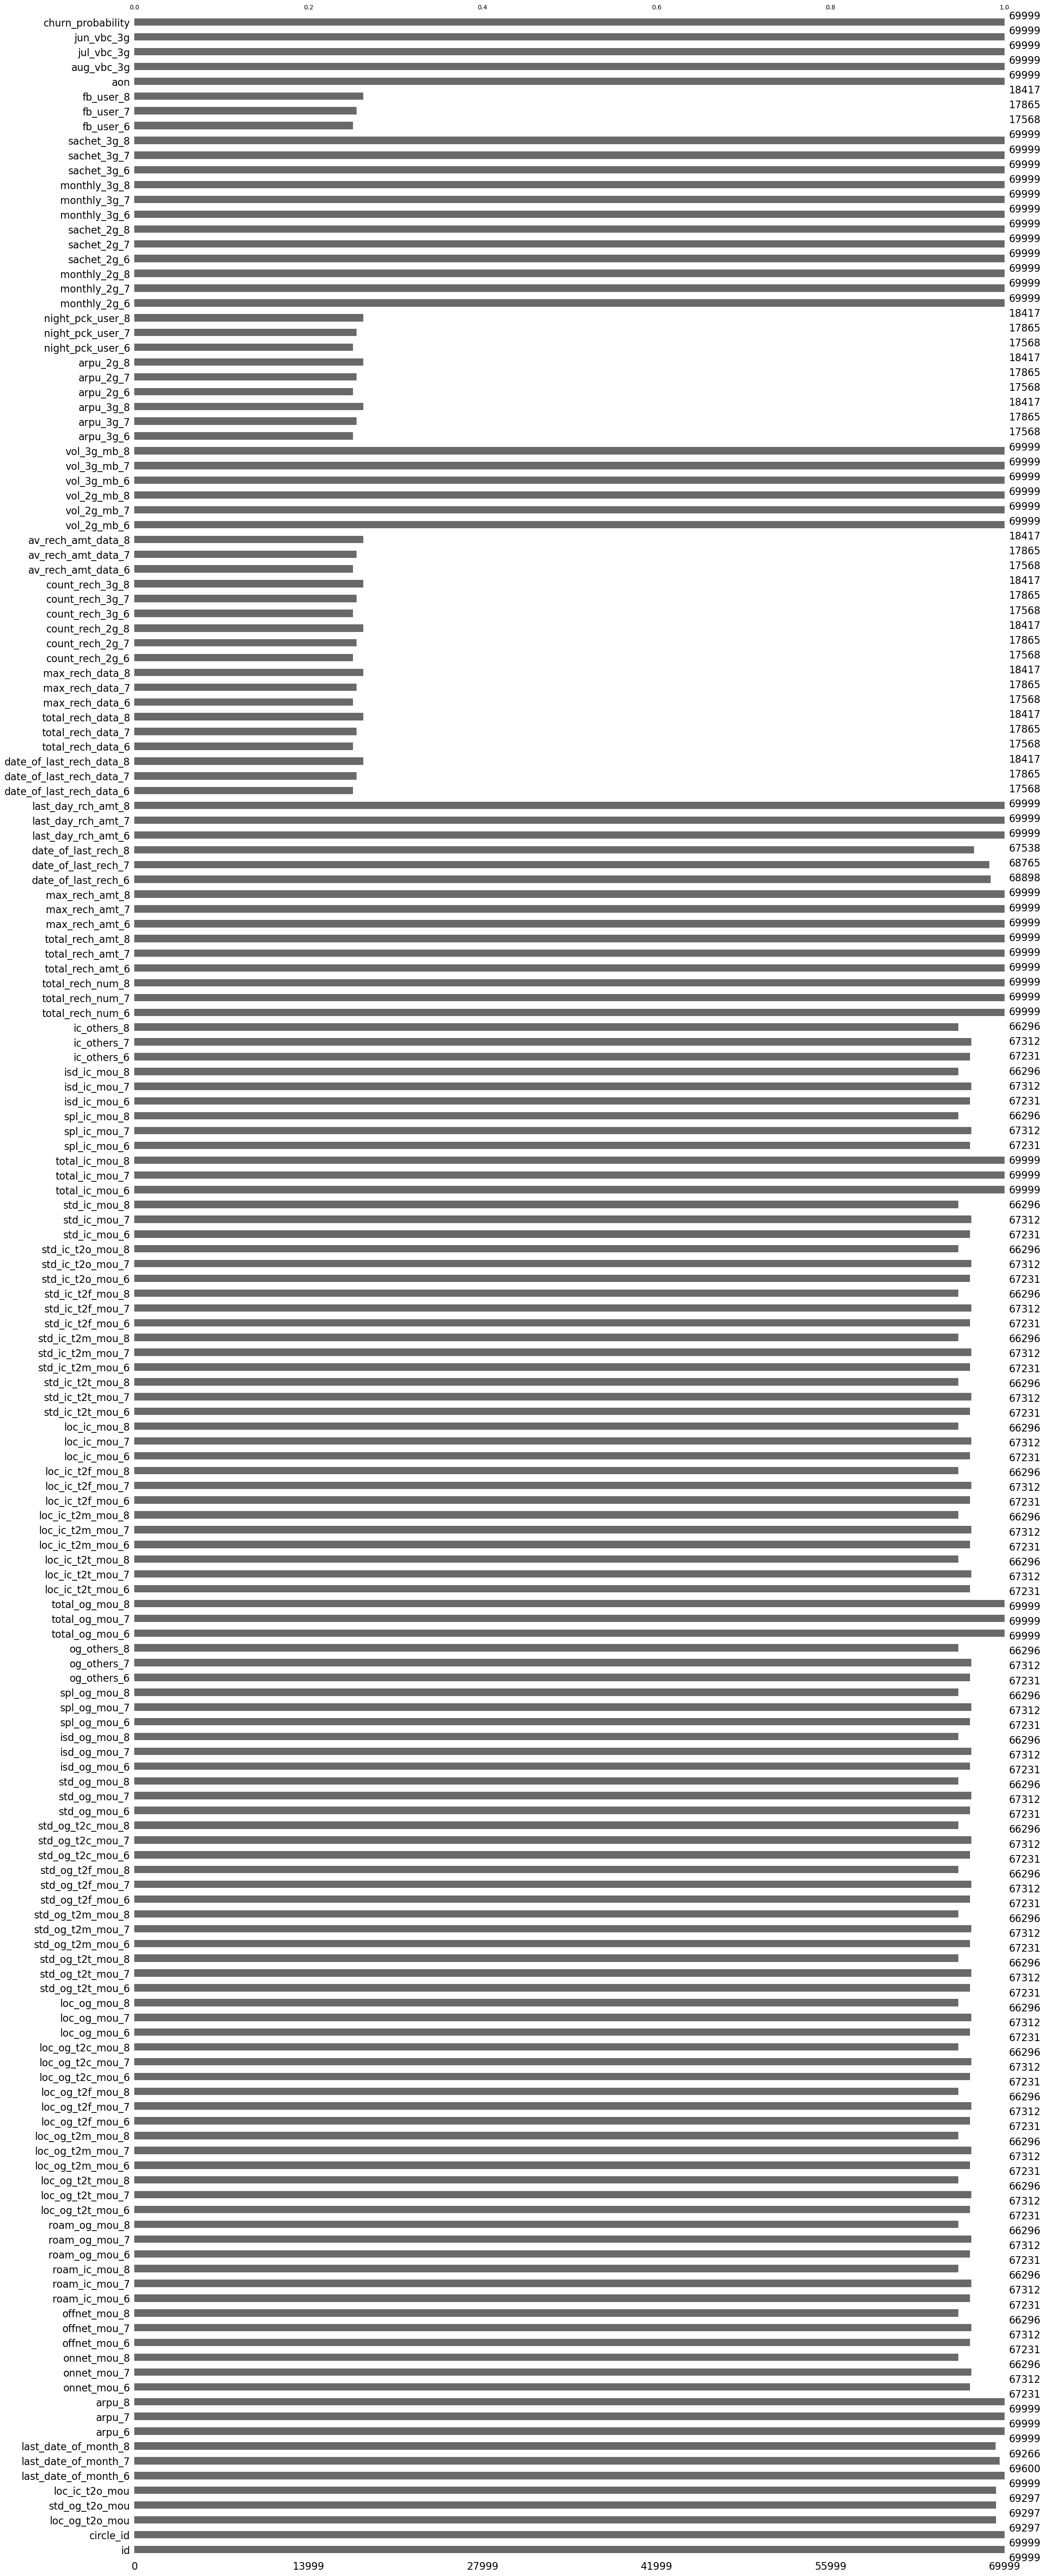

In [39]:
msno.bar(data)

<Axes: >

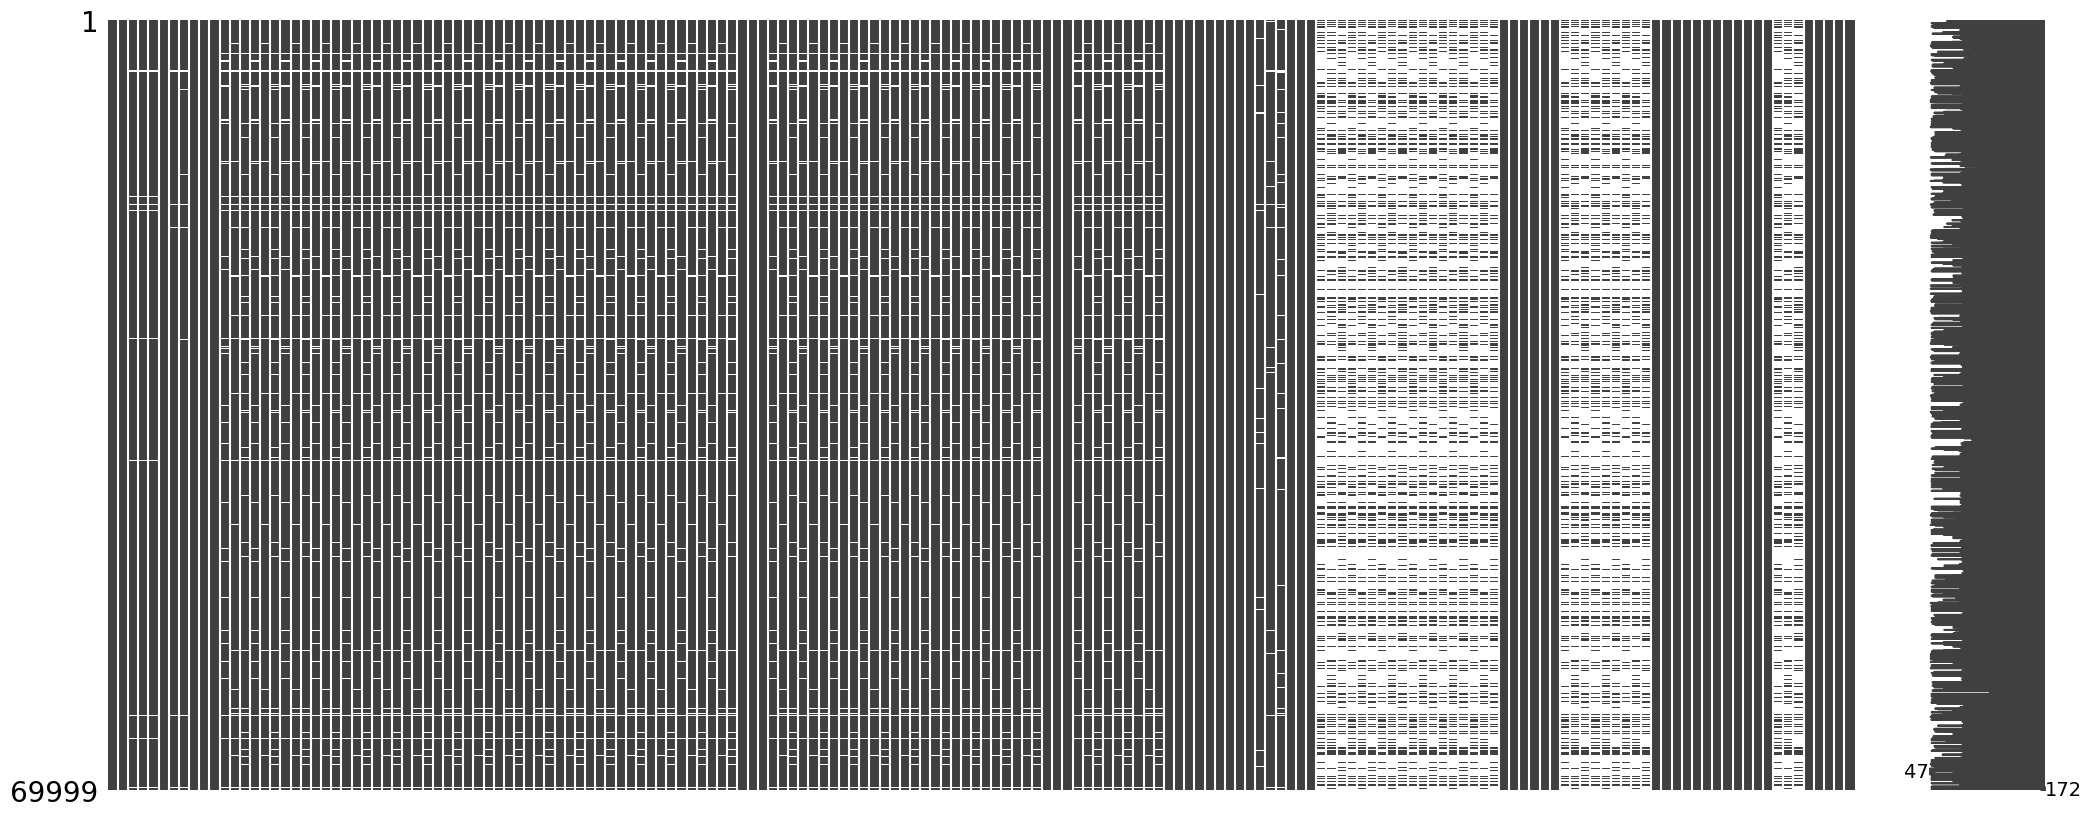

In [40]:
msno.matrix(data)

In [41]:
###Dropping NA columns.
unique_counts = data.nunique()
data_unique_columns = unique_counts[unique_counts == 1].index
data.drop(data_unique_columns, axis=1, inplace = True)




In [42]:
##dropping rows with 50% data missing. 
threshold = len(data.columns) / 2
dataclean = data.dropna(thresh=threshold,axis=0)
dataclean.shape

(68252, 159)

- Dropped rows with 50% less information.
- Columns with unique values

**FEATURE SCALING**
- Converting data_of_last_rech_* to number of days since last recharge (new column: datediff)

In [45]:
##data date:
from datetime import datetime
import pandas as pd

target_date = pd.to_datetime('8/31/2014',format='%m/%d/%Y')
df = pd.DataFrame(dataclean)

# Convert the columns to datetime
df['A'] = pd.to_datetime(dataclean['date_of_last_rech_6'],format='%m/%d/%Y')
df['B'] = pd.to_datetime(dataclean['date_of_last_rech_7'],format='%m/%d/%Y')
df['C'] = pd.to_datetime(dataclean['date_of_last_rech_8'],format='%m/%d/%Y')


# Function to compute date differences based on your conditions
def calculate_date_diff(row):
    # Convert the columns to datetime
    
    if pd.isna(row['C']):
        # If 'C' is missing, calculate the difference between 'B' and the target date
        if pd.notna(row['B']):
            return (target_date - row['B']).days
        # If 'B' is also missing, calculate the difference between 'A' and the target date
        elif pd.notna(row['A']):
            return (target_date - row['A']).days
        else:
            return None  # If both 'B' and 'A' are missing
    else:
        return (target_date - row['C']).days

# Apply the function to each row
df['date_diff'] = df.apply(calculate_date_diff, axis=1)

In [46]:
##Removing unnecessary columns.
df.drop(['A','B','C','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],inplace = True,axis=1)
df.iloc[24748]
##Assigning Df back to Dataclean
dataclean=df
dataclean.shape


(68252, 157)

In [47]:
dataclean.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,date_diff
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0,7.0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0,5.0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0,7.0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0,6.0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0,1.0


**DATA INDEXING**

In [49]:
dataclean.set_index('id')
X = dataclean.drop('churn_probability',axis=1)
y = dataclean['churn_probability']

print(X.shape)
print(y.shape)

**REMOVING COLUMNS WITH MORE THAN 30% NA**

In [52]:
missing_data_percent = 100*X.isnull().sum()/len(y)
#missing_data_percent
new_vars = missing_data_percent[missing_data_percent.le(30)].index

In [53]:
X_filtered = X[new_vars]

print(X_filtered.shape)
print(X_filtered.info(verbose=True,show_counts=True))


(68252, 126)
<class 'pandas.core.frame.DataFrame'>
Index: 68252 entries, 0 to 69998
Data columns (total 126 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    id                  68252 non-null  int64  
 1    arpu_6              68252 non-null  float64
 2    arpu_7              68252 non-null  float64
 3    arpu_8              68252 non-null  float64
 4    onnet_mou_6         66616 non-null  float64
 5    onnet_mou_7         67242 non-null  float64
 6    onnet_mou_8         65992 non-null  float64
 7    offnet_mou_6        66616 non-null  float64
 8    offnet_mou_7        67242 non-null  float64
 9    offnet_mou_8        65992 non-null  float64
 10   roam_ic_mou_6       66616 non-null  float64
 11   roam_ic_mou_7       67242 non-null  float64
 12   roam_ic_mou_8       65992 non-null  float64
 13   roam_og_mou_6       66616 non-null  float64
 14   roam_og_mou_7       67242 non-null  float64
 15   roam_og_mou_8       65992 

**IMPUTING MISSING VALUES WITH KNN IMPUTATION**

In [55]:
numcols1=list(X_filtered.select_dtypes(include=['int64','float64']).columns)
#print(numcols)
##imputing KNN Imputation:
imputer = KNNImputer(n_neighbors=4)
for column1 in numcols1:
    print(column1)
    X_filtered[column1] = imputer.fit_transform(X_filtered[[column1]])




id
arpu_6
arpu_7
arpu_8
onnet_mou_6
onnet_mou_7
onnet_mou_8
offnet_mou_6
offnet_mou_7
offnet_mou_8
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc_ic_t2m_mou_6
loc_ic_t2m_mou_7
loc_ic_t2m_mou_8
loc_ic_t2f_mou_6
loc_ic_t2f_mou_7
loc_ic_t2f_mou_8
loc_ic_mou_6
loc_ic_mou_7
loc_ic_mou_8
std_ic_t2t_mou_6
std_ic_t2t_mou

In [56]:
X_filtered.head()
X.set_index('id')

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_diff
id,,,,,,,,,,,,,,,,,,,,,
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,7.0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,0,NaN,1.0,NaN,710,0.00,0.00,0.00,5.0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,0,NaN,NaN,NaN,882,0.00,0.00,0.00,7.0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,0,NaN,NaN,NaN,982,0.00,0.00,0.00,6.0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,1,0,NaN,1.0,1.0,221,0.00,0.00,0.00,0.0
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,0,NaN,NaN,NaN,712,0.00,0.00,0.00,4.0
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,0,NaN,NaN,NaN,879,0.00,0.00,0.00,2.0


**GRAPH on MISSING COLUMN %**

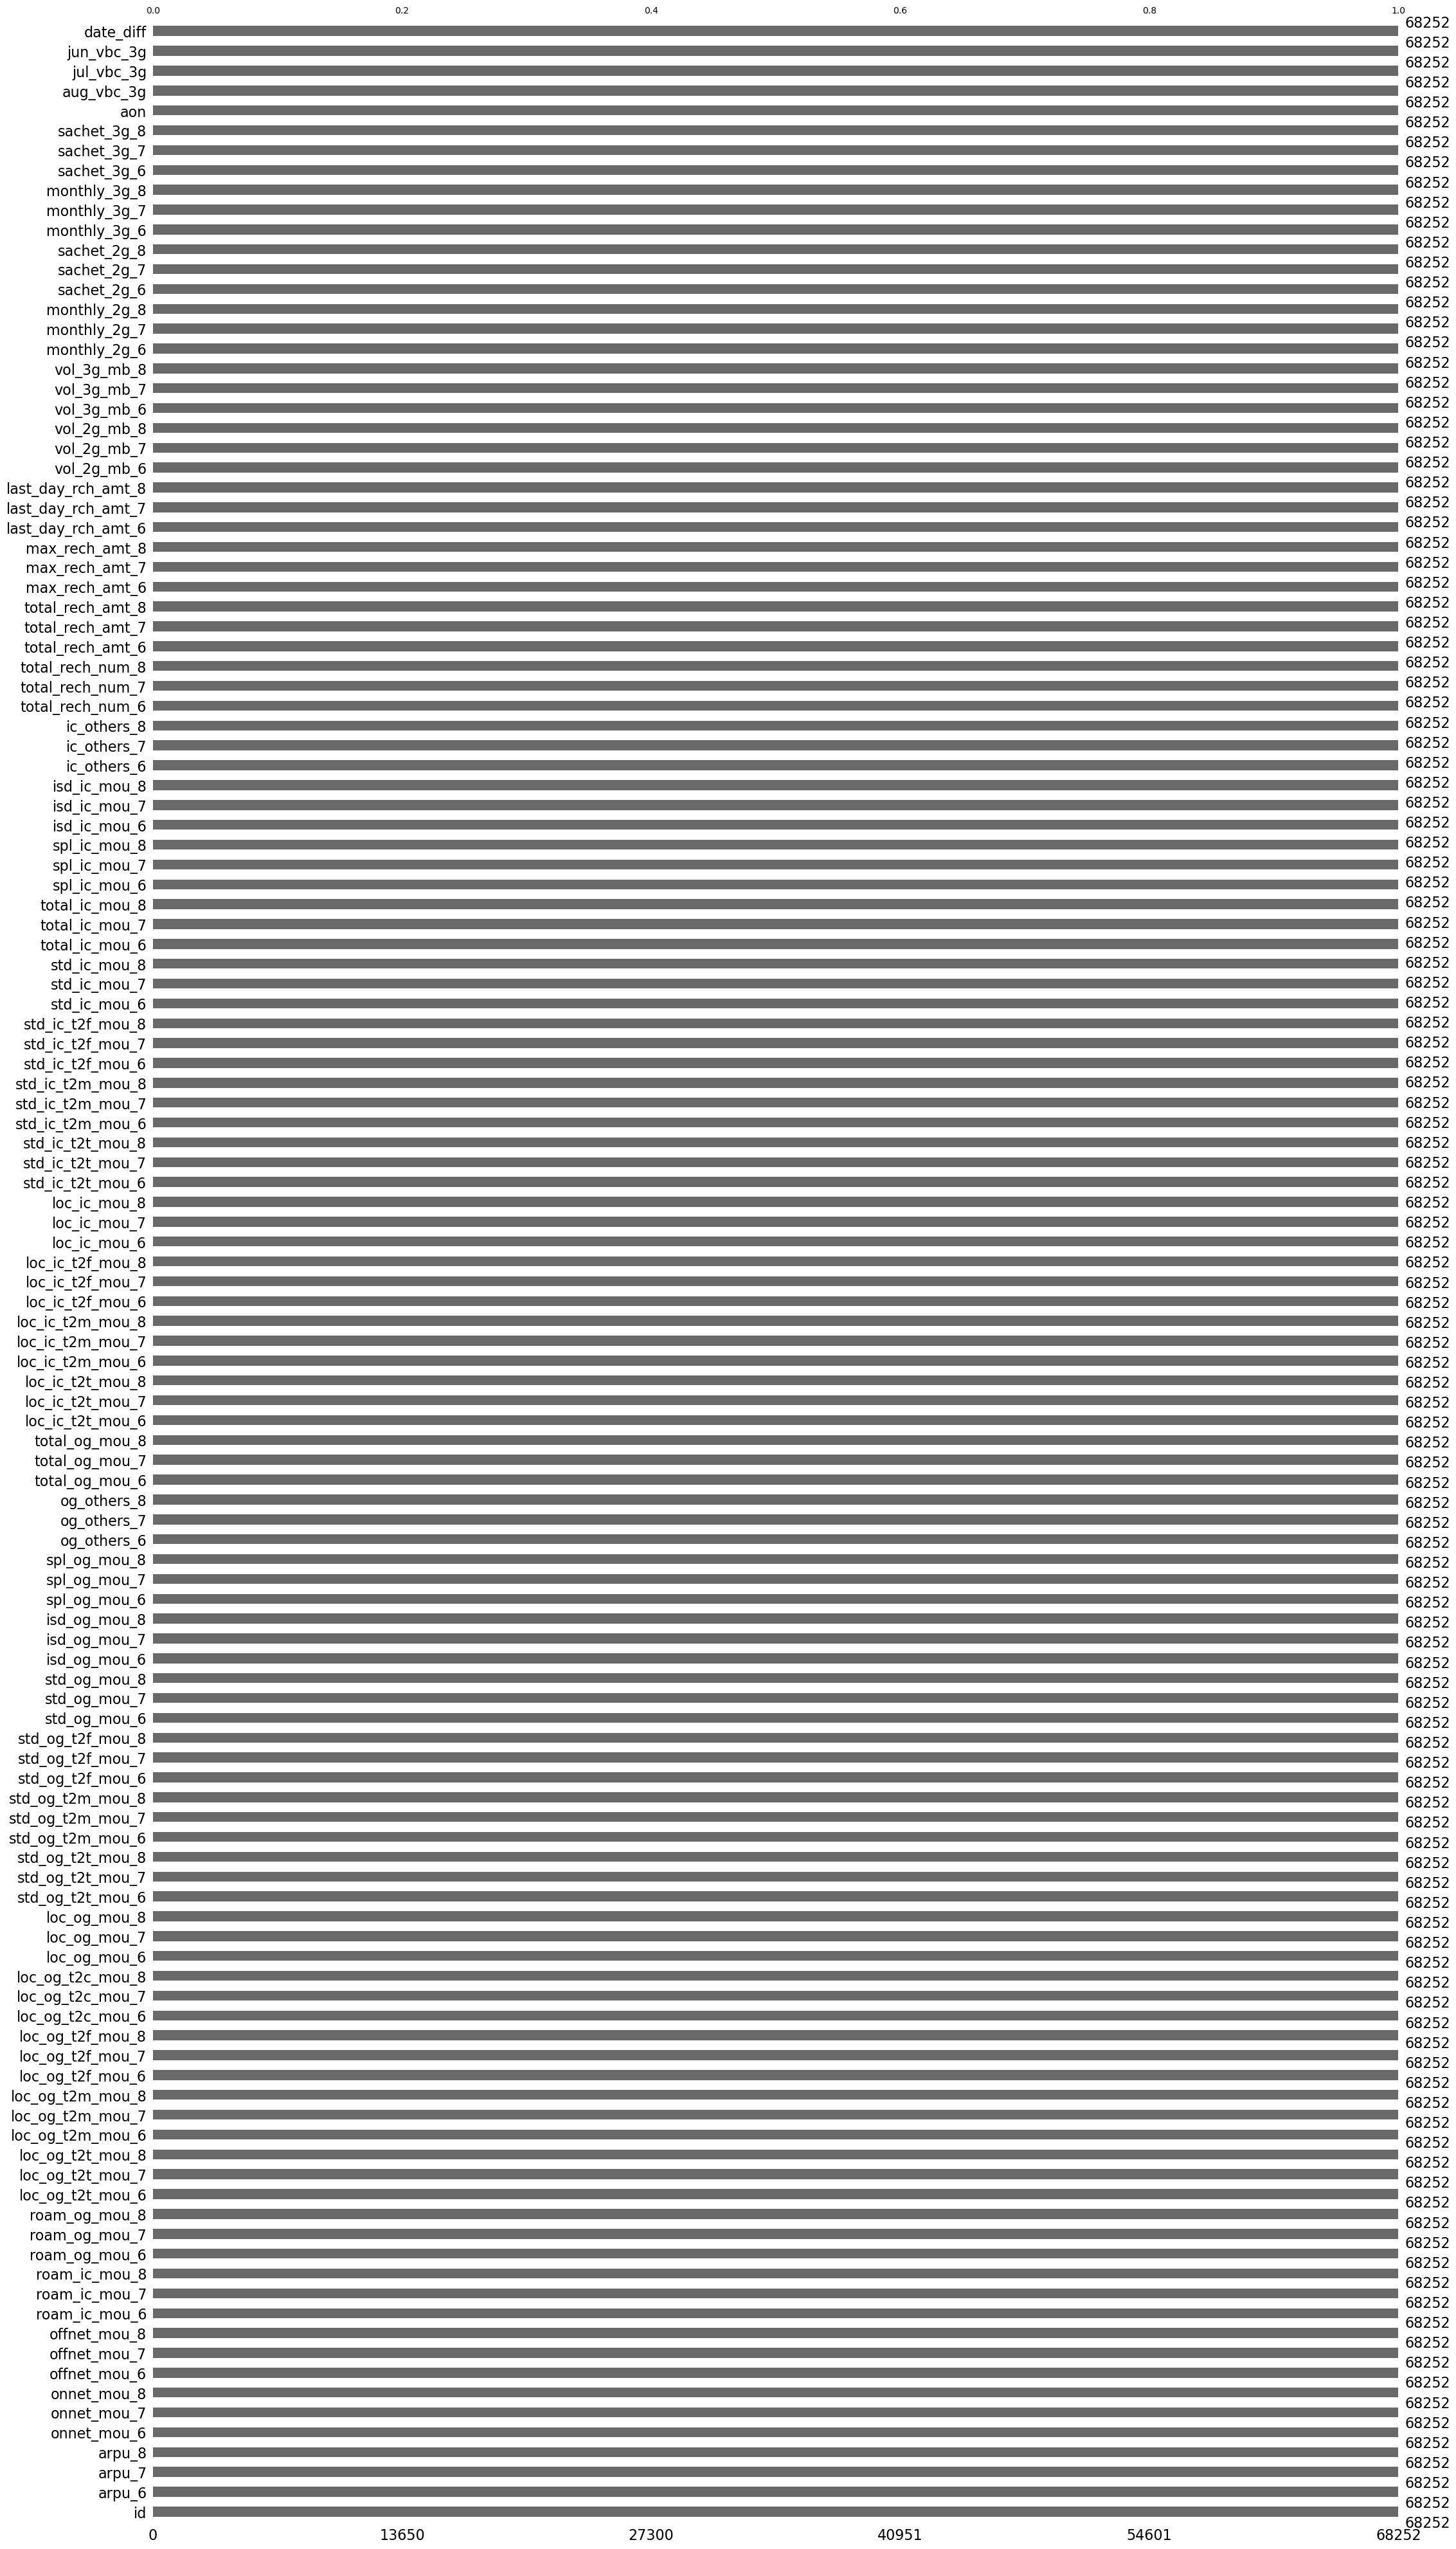

In [58]:
import missingno as msno

msno.bar(X_filtered)
plt.show()


In [59]:
X_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 68252 entries, 0 to 69998
Data columns (total 126 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    id                  68252 non-null  float64
 1    arpu_6              68252 non-null  float64
 2    arpu_7              68252 non-null  float64
 3    arpu_8              68252 non-null  float64
 4    onnet_mou_6         68252 non-null  float64
 5    onnet_mou_7         68252 non-null  float64
 6    onnet_mou_8         68252 non-null  float64
 7    offnet_mou_6        68252 non-null  float64
 8    offnet_mou_7        68252 non-null  float64
 9    offnet_mou_8        68252 non-null  float64
 10   roam_ic_mou_6       68252 non-null  float64
 11   roam_ic_mou_7       68252 non-null  float64
 12   roam_ic_mou_8       68252 non-null  float64
 13   roam_og_mou_6       68252 non-null  float64
 14   roam_og_mou_7       68252 non-null  float64
 15   roam_og_mou_8       68252 non-null  flo

# 3. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

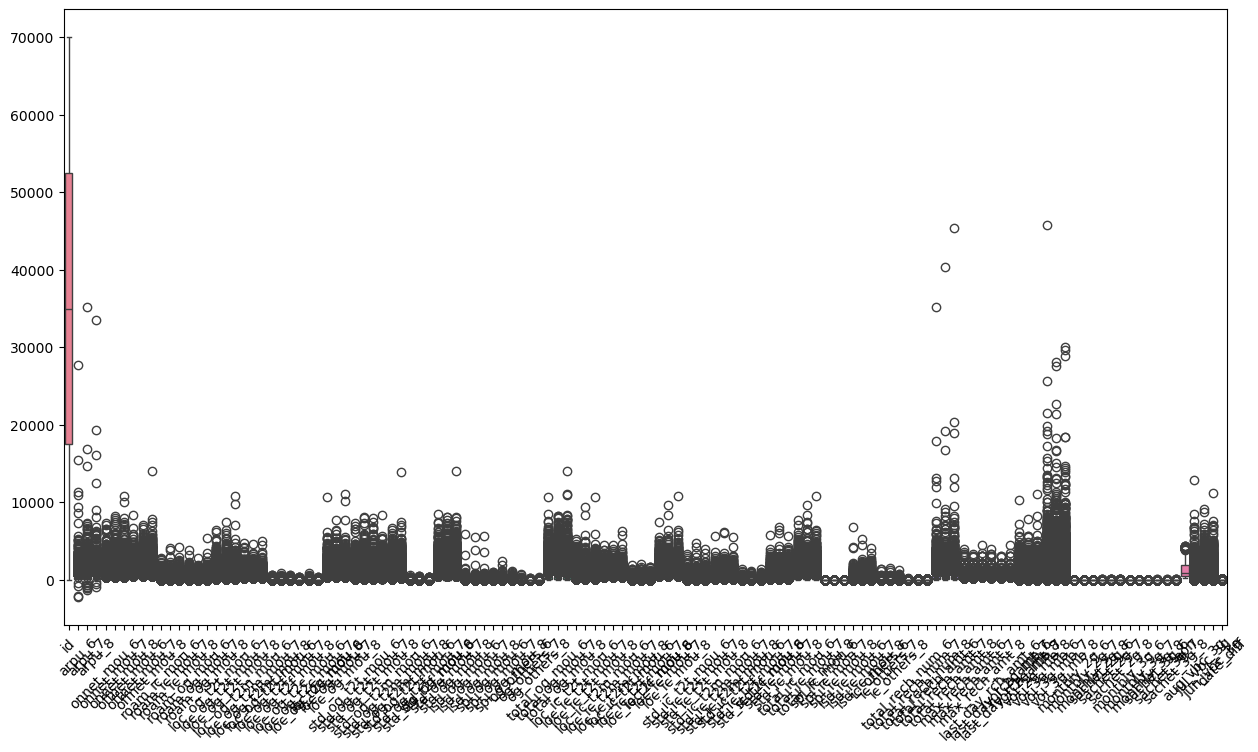

In [61]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_filtered)

**HEATMAP to find Co-relation between columns and cleanup**

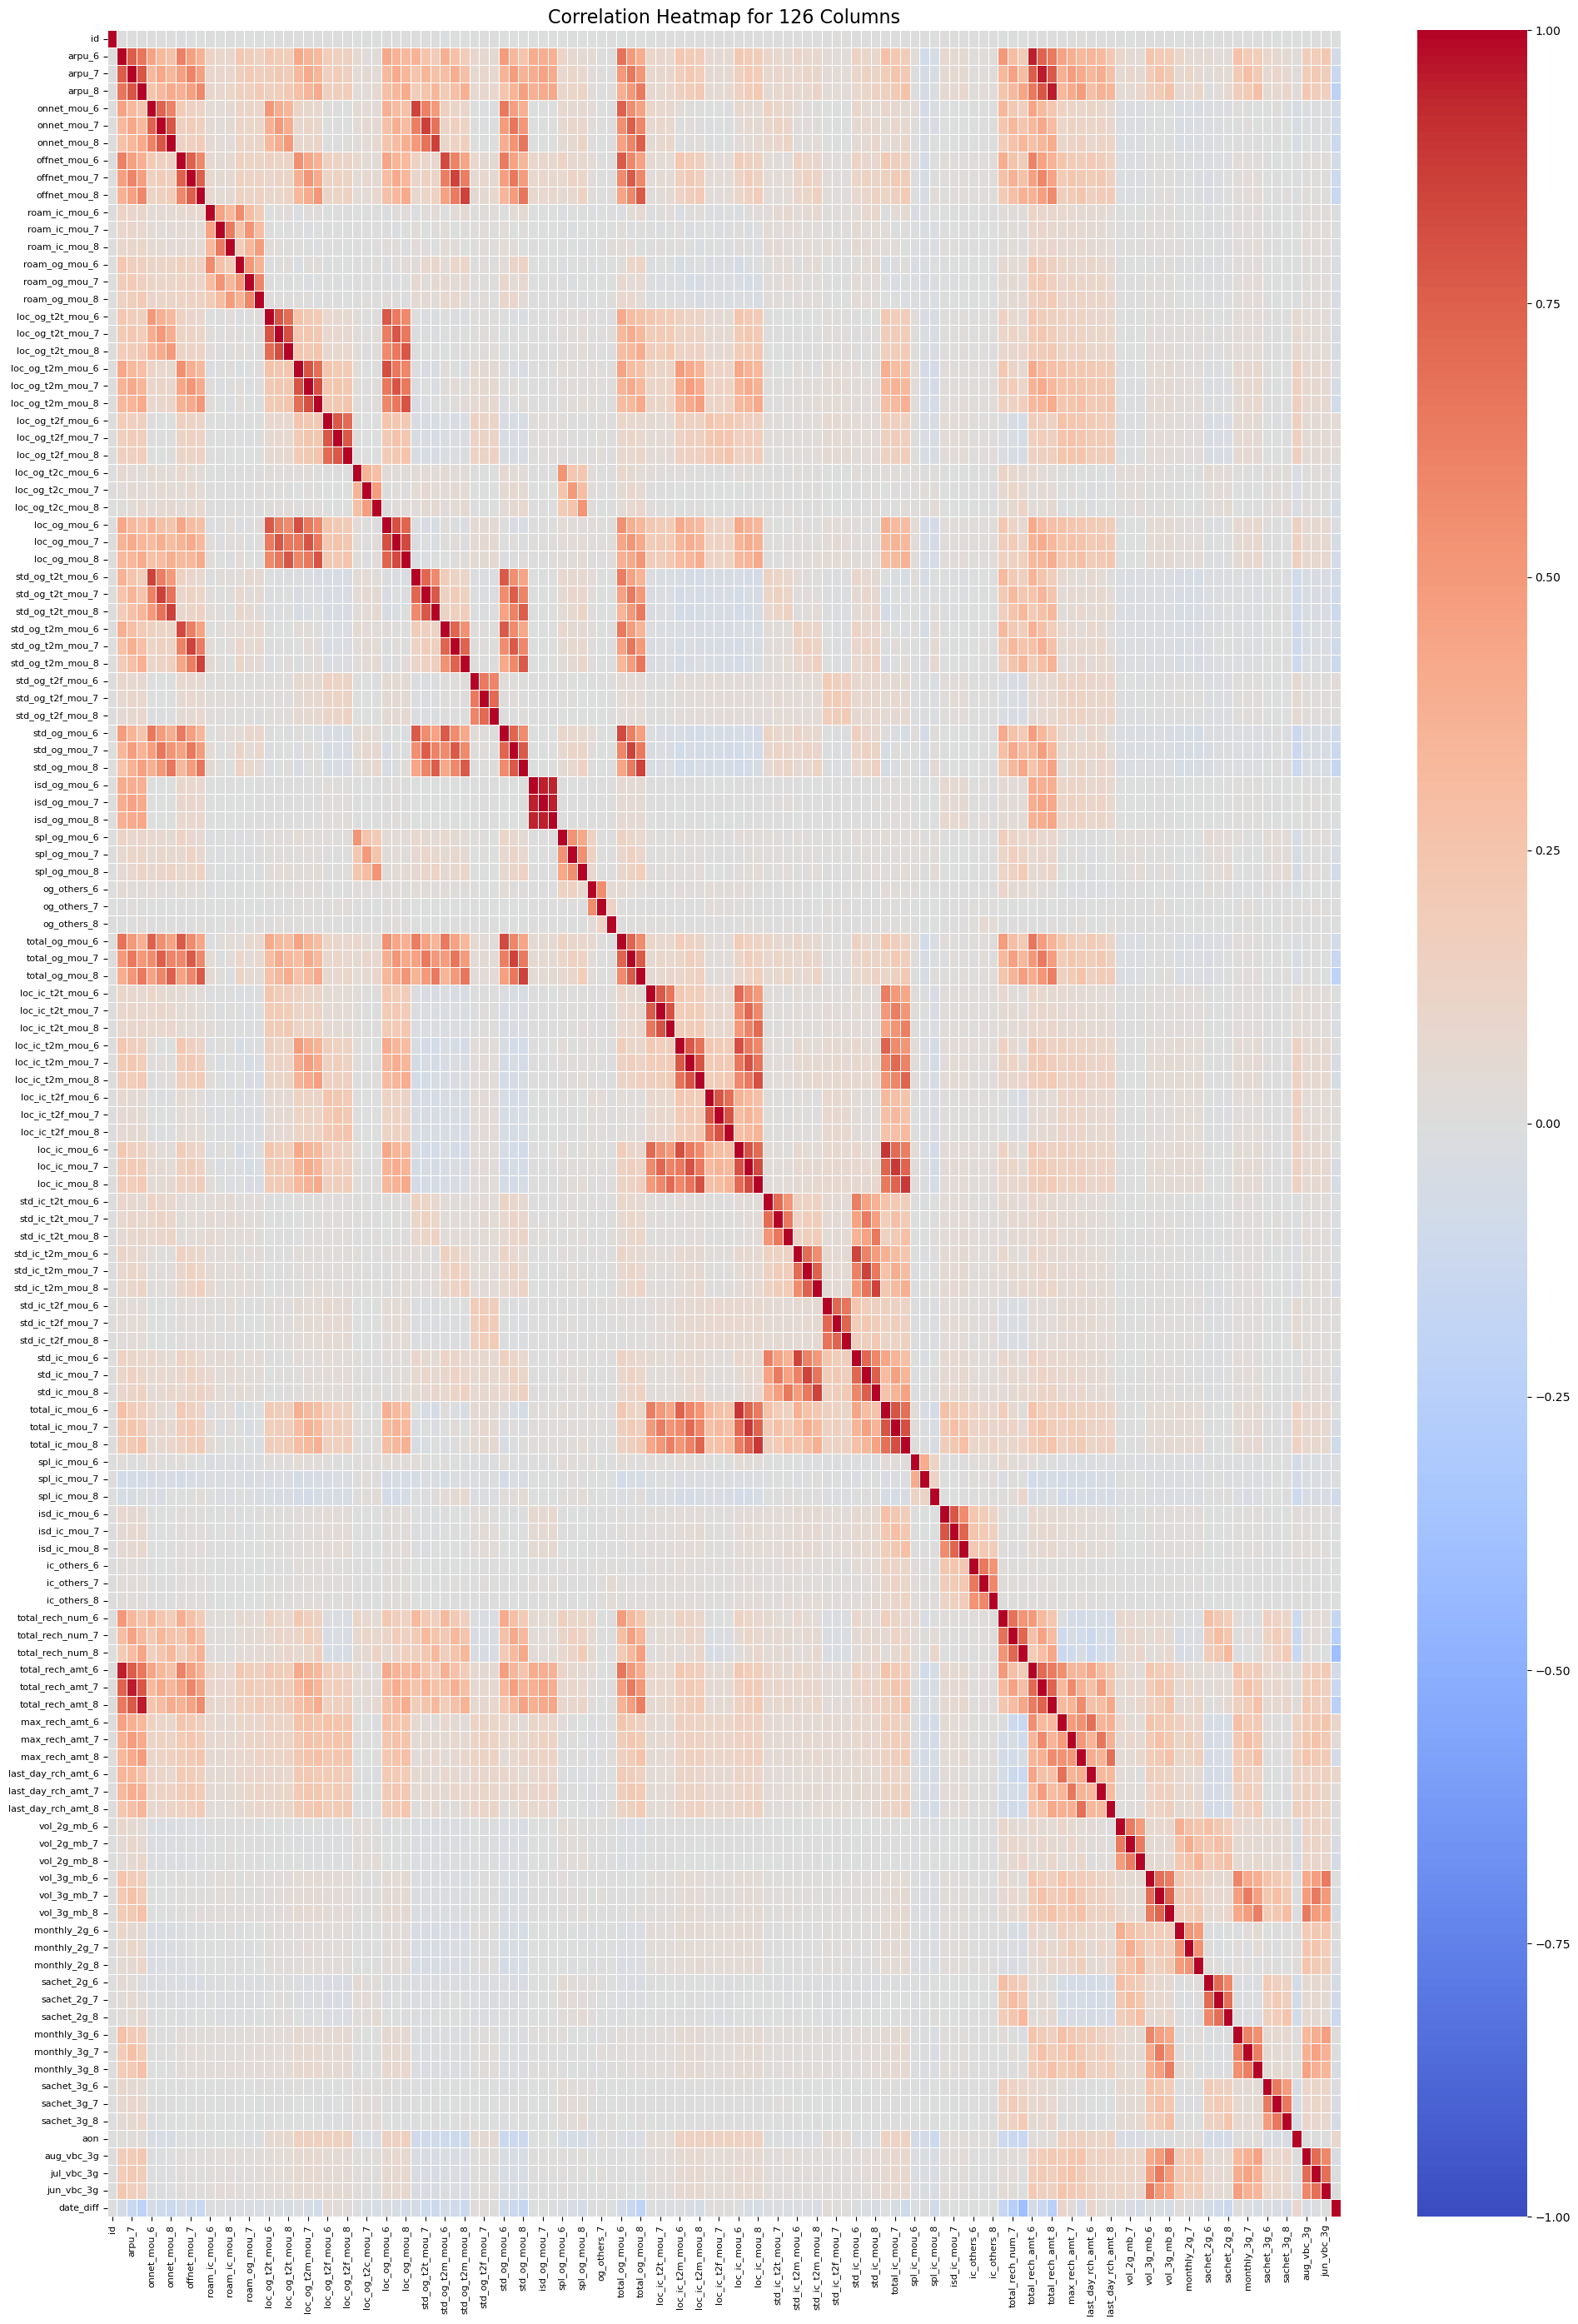

In [63]:

# Set up the matplotlib figure
plt.figure(figsize=(20, 28))

# Create the heatmap
sns.heatmap(X_filtered.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Adjust the labels for clarity (rotating labels if needed)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Title
plt.title("Correlation Heatmap for 126 Columns", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

In [64]:

# Compute the correlation matrix
corr_matrix = X_filtered.corr()

# Set the threshold for strong correlation (absolute value of 0.8)
threshold = 0.8

# Mask the correlation matrix to find values above the threshold (positive or negative)
strong_corr = corr_matrix[(corr_matrix.abs() >= threshold) & (corr_matrix != 1)]

# Extract the column pairs (indices) and their correlation values
strong_corr_pairs = strong_corr.stack().reset_index()
strong_corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

pd.set_option('display.max_columns', None)  # No limit on columns
pd.set_option('display.max_rows', None)  # No limit on rows
# Display the results
print(strong_corr_pairs)



            Column 1          Column 2  Correlation
0             arpu_6  total_rech_amt_6     0.953011
1             arpu_7  total_rech_amt_7     0.955360
2             arpu_8  total_rech_amt_8     0.958719
3        onnet_mou_6  std_og_t2t_mou_6     0.853870
4        onnet_mou_7  std_og_t2t_mou_7     0.862144
5        onnet_mou_8  std_og_t2t_mou_8     0.862137
6       offnet_mou_6  std_og_t2m_mou_6     0.831031
7       offnet_mou_7  std_og_t2m_mou_7     0.855792
8       offnet_mou_8  std_og_t2m_mou_8     0.857761
9   loc_og_t2t_mou_7  loc_og_t2t_mou_8     0.814456
10  loc_og_t2t_mou_8  loc_og_t2t_mou_7     0.814456
11  loc_og_t2m_mou_6      loc_og_mou_6     0.813419
12  loc_og_t2m_mou_7  loc_og_t2m_mou_8     0.810779
13  loc_og_t2m_mou_8  loc_og_t2m_mou_7     0.810779
14      loc_og_mou_6  loc_og_t2m_mou_6     0.813419
15      loc_og_mou_6      loc_og_mou_7     0.810719
16      loc_og_mou_7      loc_og_mou_6     0.810719
17      loc_og_mou_7      loc_og_mou_8     0.830867
18      loc_

In [65]:
corr_matrix = X_filtered.corr()
# Set a correlation threshold
threshold = 0.8
# Create a mask for the correlation values greater than or equal to the threshold, including negative correlations
# Exclude the diagonal elements (correlation of a column with itself)
mask = (corr_matrix.abs() >= threshold) & (corr_matrix != 1)
# List to store columns to drop
columns_to_drop = set()
# Iterate over the correlation matrix to identify highly correlated columns
for row in range(len(corr_matrix.columns)):
    for col in range(row):
        if mask.iloc[row, col]:
            # If the correlation is above the threshold (either positive or negative),
            # add one of the columns to drop
            colname = corr_matrix.columns[col]
            columns_to_drop.add(colname)

# Print the cleaned DataFrame
print("Columns to drop:", columns_to_drop)

X_heatmap = X_filtered
# Drop the identified columns from the DataFrame
X_heatmap = X_heatmap.drop(columns=columns_to_drop)
print(X_heatmap.shape)




Columns to drop: {'total_ic_mou_7', 'loc_ic_mou_6', 'isd_og_mou_6', 'arpu_7', 'loc_ic_t2m_mou_8', 'std_ic_t2m_mou_8', 'loc_ic_t2m_mou_6', 'loc_og_t2m_mou_6', 'loc_ic_mou_8', 'arpu_8', 'loc_og_t2m_mou_7', 'offnet_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_6', 'onnet_mou_6', 'std_og_mou_7', 'offnet_mou_8', 'onnet_mou_8', 'loc_og_mou_7', 'loc_ic_mou_7', 'loc_og_t2t_mou_7', 'std_og_mou_8', 'loc_og_mou_6', 'loc_ic_t2t_mou_7', 'arpu_6', 'std_og_mou_6', 'isd_og_mou_7', 'offnet_mou_6', 'onnet_mou_7'}
(68252, 97)


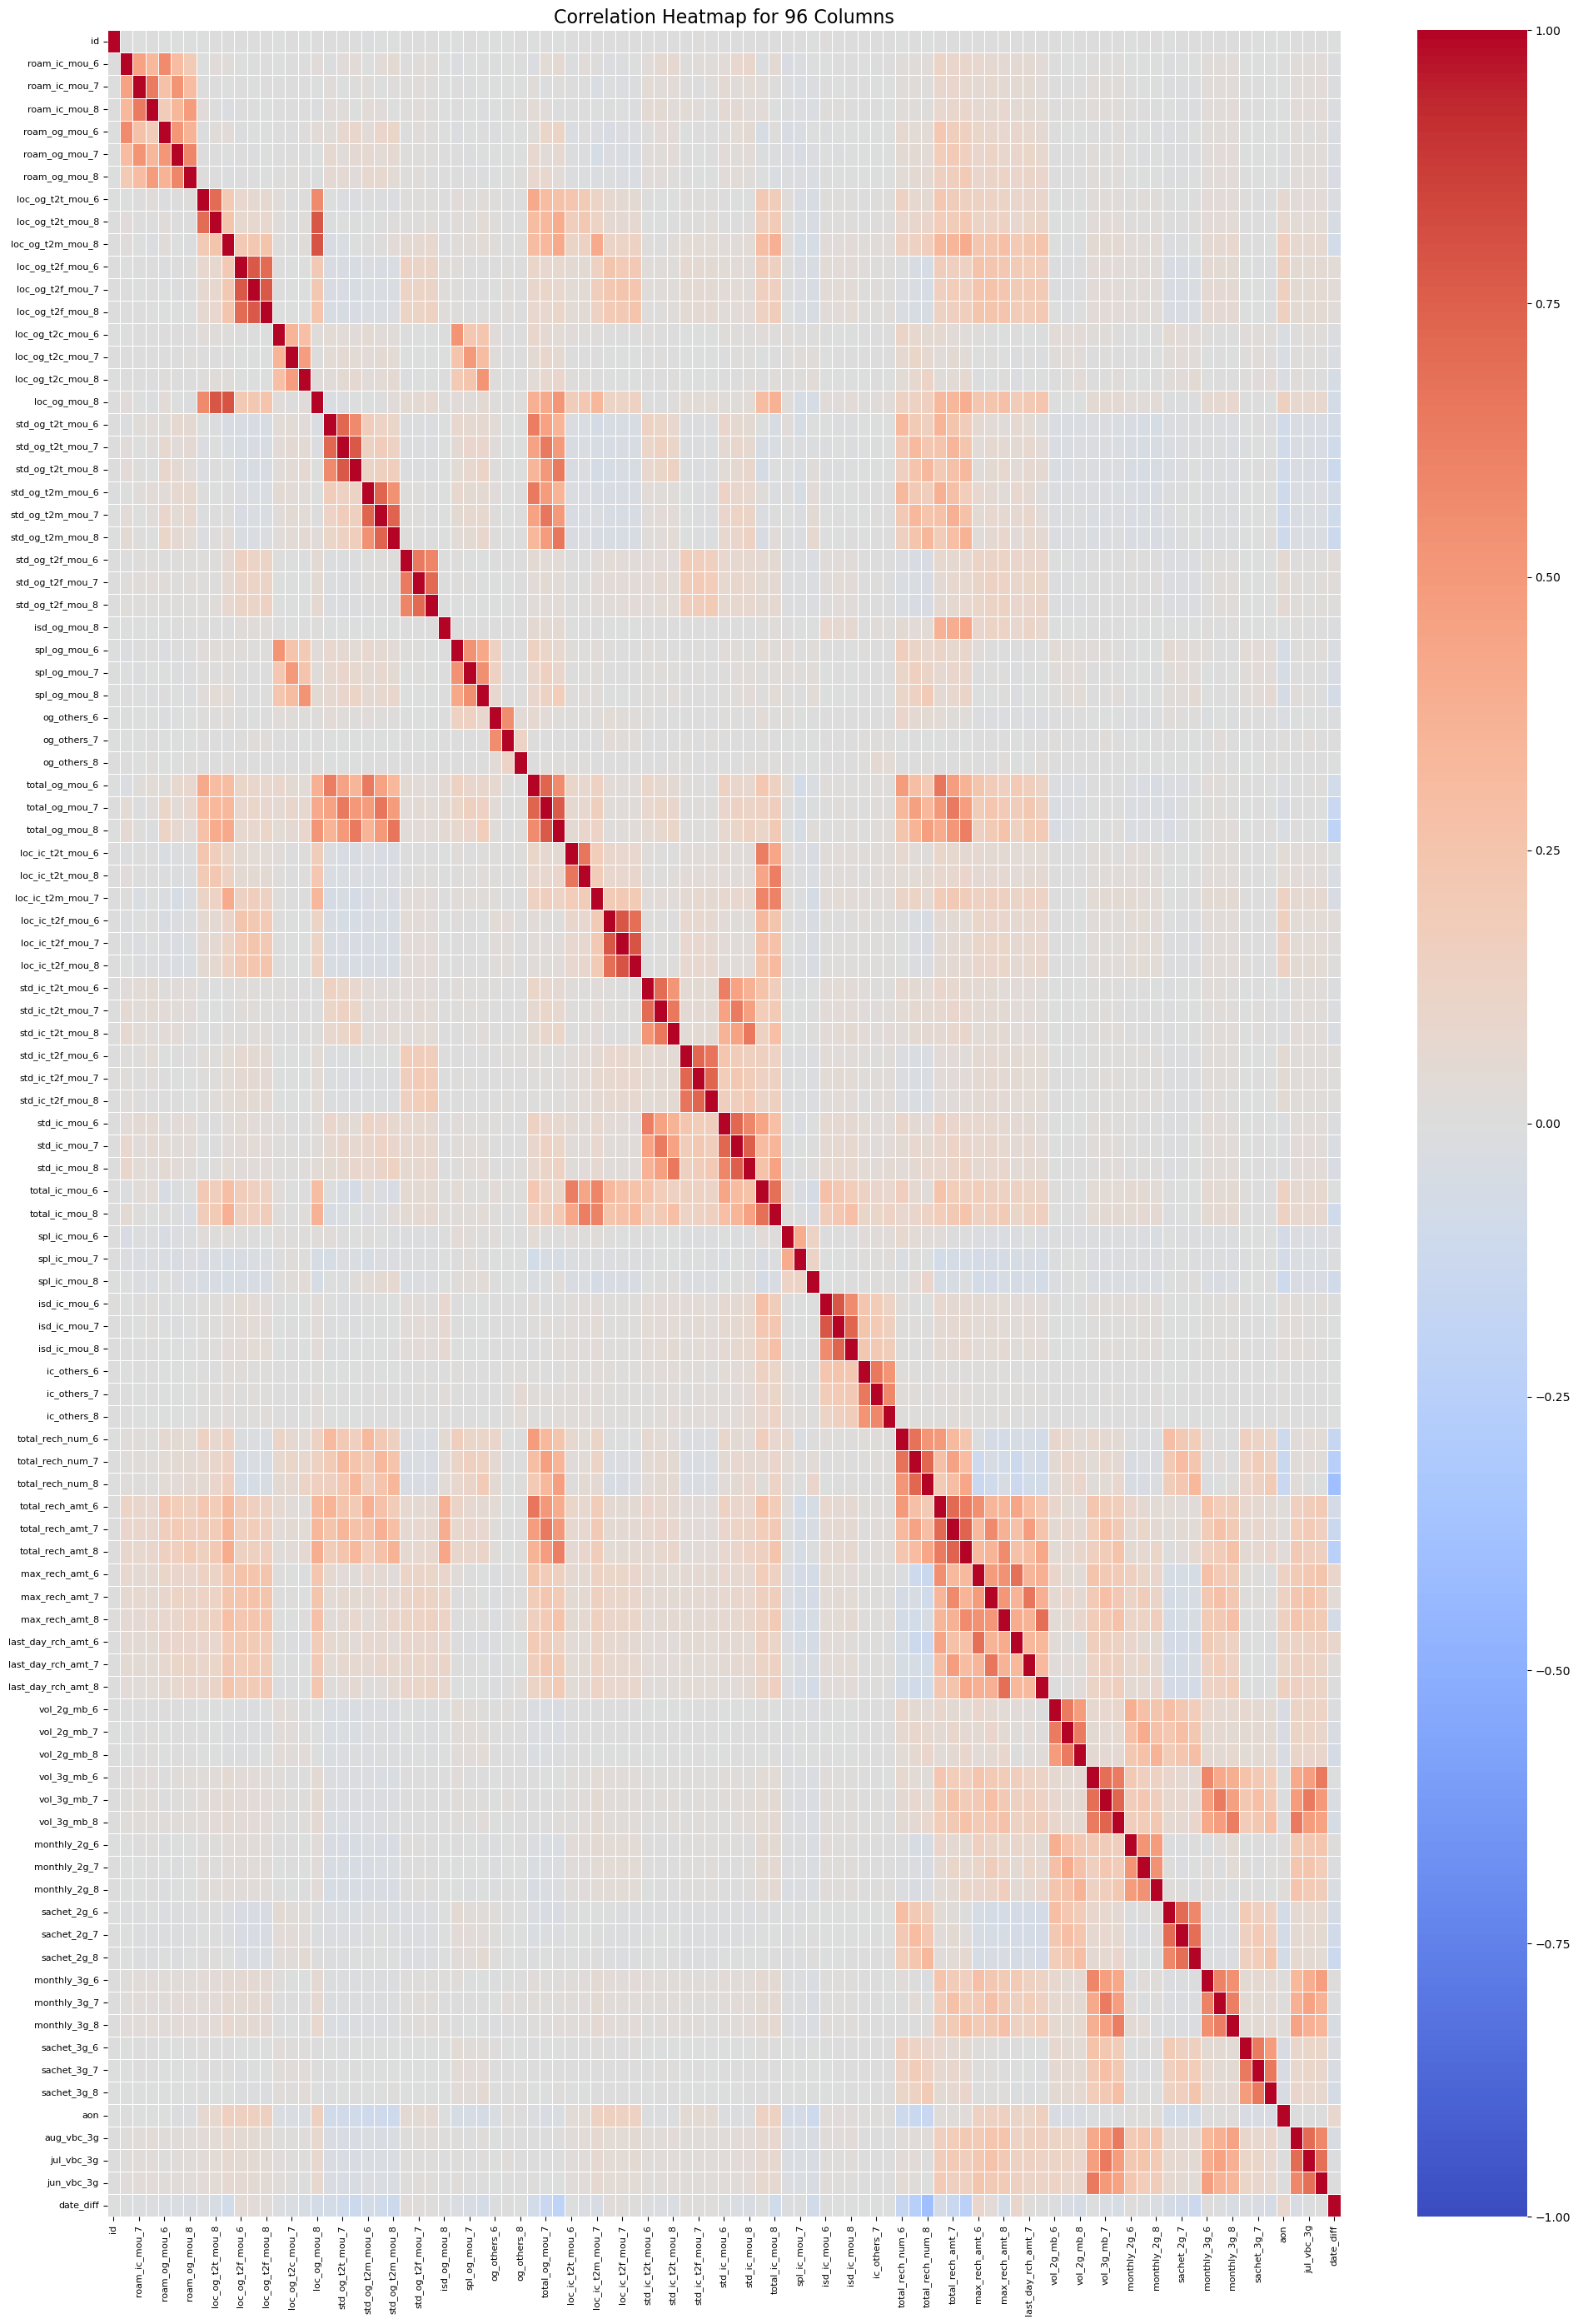

In [66]:
##checking heatmap after dropping columns with high co-relation
# Set up the matplotlib figure
plt.figure(figsize=(20, 28))

# Create the heatmap
sns.heatmap(X_heatmap.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Adjust the labels for clarity (rotating labels if needed)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Title
plt.title("Correlation Heatmap for 96 Columns", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

In [67]:
# Compute the correlation matrix
corr_matrix = X_heatmap.corr()

# Set the threshold for strong correlation (absolute value of 0.8)
threshold = 0.8

# Mask the correlation matrix to find values above the threshold (positive or negative)
strong_corr = corr_matrix[(corr_matrix.abs() >= threshold) & (corr_matrix != 1)]

# Extract the column pairs (indices) and their correlation values
strong_corr_pairs = strong_corr.stack().reset_index()
strong_corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

pd.set_option('display.max_columns', None)  # No limit on columns
pd.set_option('display.max_rows', None)  # No limit on rows
# Display the results
print(strong_corr_pairs)

Empty DataFrame
Columns: [Column 1, Column 2, Correlation]
Index: []


- Removed columns with more than 80% corelation

**OUTLIERS TREATMENT**

In [70]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

X_outlier = X_heatmap.apply(cap_outliers, axis=0)



In [71]:
print(X_outlier.shape)
print(y.shape)


(68252, 97)
(68252,)


In [72]:
X_outlier.head()

,id,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_8,loc_ic_t2m_mou_7,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_diff
0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.28,2.33,0.00,0.00,0.00,0.00,0.00,0.000000,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,7.79,21.08,0.00,0.00,0.00,0.00,7.61,0.21,0.0,0.0,0.0,7.46,27.58,15.18,11.84,40.56,0.0,0.0,0.478107,0.0,0.0,0.0,1.11,0.69,0.00,3.0,2.0,2.0,77.0,65.0,10.0,65.0,65.0,10.0,65.0,65.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1958.0,0.0,0.0,0.0,7.0
1,1.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,20.729296,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,10.53,18.68,0.35,1.66,3.40,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,25.04,0.0,0.0,0.010000,0.0,0.0,0.0,0.00,0.00,0.00,3.0,4.0,5.0,0.0,145.0,50.0,0.0,145.0,50.0,0.0,0.0,0.0,0.0,352.91,0.00,0.0,3.96,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0,5.0
2,2.0,0.00,0.0,0.0,0.00,0.0,0.00,0.53,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.000000,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.49,25.18,0.00,0.00,0.00,11.69,0.00,0.00,0.0,0.0,0.0,29.91,2.48,6.38,124.29,36.64,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.25,2.0,4.0,2.0,70.0,120.0,0.0,70.0,70.0,0.0,70.0,50.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,882.0,0.0,0.0,0.0,7.0
3,3.0,0.00,0.0,0.0,0.00,0.0,1.63,6.99,0.00,23.63,0.00,0.00,0.00,0.00,0.00,8.030000,23.63,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,24.98,23.88,44.23,7.23,0.81,0.00,0.00,0.00,0.00,0.0,0.0,0.0,8.89,0.28,2.81,95.11,83.84,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,2.0,4.0,3.0,160.0,240.0,130.0,110.0,110.0,50.0,110.0,110.0,50.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,982.0,0.0,0.0,0.0,6.0
4,4.0,53.64,0.0,0.0,15.73,0.0,0.00,10.16,6.13,4.61,11.99,1.23,5.01,0.00,9.85,0.000000,15.76,0.00,0.00,0.00,4.35,0.00,0.0,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,5.44,2.66,4.33,5.51,3.63,6.14,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,21.54,28.31,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,13.0,10.0,8.0,290.0,136.0,122.0,50.0,41.0,30.0,25.0,10.0,30.0,390.8,308.89,213.47,0.0,0.00,0.0,0.0,0.0,0.0,4.930021,5.459884,5.412184,0.0,0.0,0.0,0.0,1.0,0.0,647.0,0.0,0.0,0.0,1.0


<Axes: >

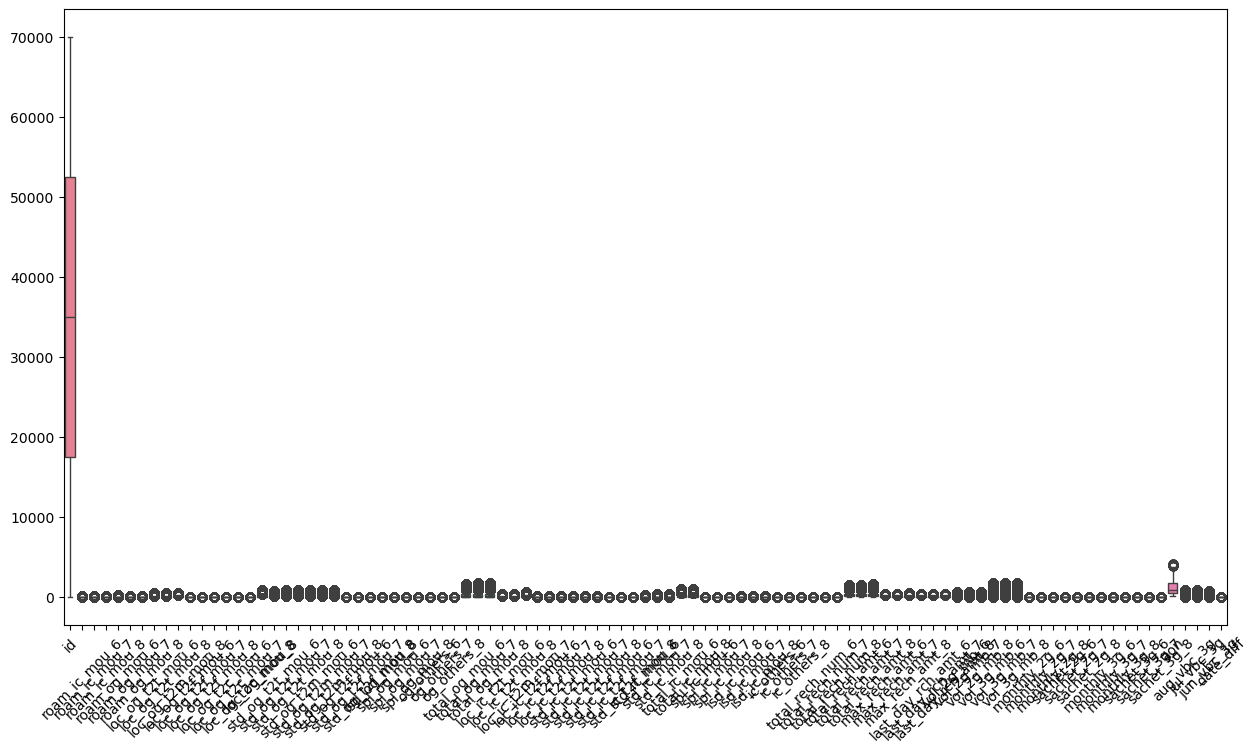

In [73]:

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_outlier)

# 4. Create X, y and then Train test split

Lets create X and y datasets

In [75]:
X_train,X_test,y_train,y_test=train_test_split(X_outlier,y,test_size=0.3,random_state=42,stratify=y)

In [76]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(47776, 97)
(20476, 97)
(47776,)
(20476,)


# 5. Feature engineering and selection

- Scaling dataset.
- Using RFE with RandomForestClassifier to select optimal features. (80% of features chosen)


Optimal paratmers for "RandomForestClassifier" selected via GRIDSEARCH and RANDOMISED SEARCH

Code:

from sklearn.model_selection import RandomizedSearchCV

Set up a Random Forest Classifier:
rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')

Define the parameter grid for GridSearchCV and RandomisedSearchCV:-
param_grid = {
    'n_estimators': [50, 100, 125, 150,200,300],           # Number of trees in the forest
    'max_depth': [5, 10, 20, 30, 40],          # Maximum depth of the trees
    'min_samples_split': [5,10,15], 
}


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
OR
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=10, cv=5, verbose=2, n_jobs=-1)

random_search.fit(X_train_filtered2, y_train)

Print the best parameters found:-
print("Best hyperparameters:", random_search.best_params_)

Make predictions using the best model:-
best_rf_model = random_search.best_estimator_
print(best_rf_model)

In [78]:

scale = StandardScaler()
X_train_filtered = scale.fit_transform(X_train)
X_test_filtered = scale.transform(X_test)



In [79]:
X_train_filtered=pd.DataFrame(X_train_filtered)
X_test_filtered=pd.DataFrame(X_test_filtered)
X_train_filtered.columns = X_train.columns
X_test_filtered.columns = X_test.columns

In [80]:
from sklearn.feature_selection import RFE
rf_classifier = RandomForestClassifier(class_weight='balanced', max_depth=40,min_samples_split=15, n_estimators=200, random_state=42)
percentage = 0.80
features_to_select = int(X_train_filtered.shape[1] * percentage)

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(rf_classifier, n_features_to_select=features_to_select)
rfe.fit(X_train_filtered, y_train)
# Get the mask of selected features (True for selected features, False for removed)
selected_features_mask = rfe.support_
# Get the selected feature names
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('id', True, 1),
 ('roam_ic_mou_6', True, 1),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', True, 1),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', True, 1),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', True, 1),
 ('loc_og_t2f_mou_7', True, 1),
 ('loc_og_t2f_mou_8', True, 1),
 ('loc_og_t2c_mou_6', True, 1),
 ('loc_og_t2c_mou_7', True, 1),
 ('loc_og_t2c_mou_8', True, 1),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', True, 1),
 ('std_og_t2t_mou_7', True, 1),
 ('std_og_t2t_mou_8', True, 1),
 ('std_og_t2m_mou_6', True, 1),
 ('std_og_t2m_mou_7', True, 1),
 ('std_og_t2m_mou_8', True, 1),
 ('std_og_t2f_mou_6', False, 8),
 ('std_og_t2f_mou_7', False, 10),
 ('std_og_t2f_mou_8', True, 1),
 ('isd_og_mou_8', True, 1),
 ('spl_og_mou_6', True, 1),
 ('spl_og_mou_7', True, 1),
 ('spl_og_mou_8', True, 1),
 ('og_others_6', True, 1),
 ('og_others_7', False, 21),
 ('og_others_8', True, 1),
 ('tot

In [81]:
selected_feature_names = [X_train_filtered.columns[i] for i in range(len(X_train_filtered.columns)) if selected_features_mask[i]]
print("Selected feature names:", selected_feature_names,len(selected_feature_names))

Selected feature names: ['id', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_

# 6. Model building

- Created PIPELINE for BUILDING MODEL
- With KNN imputer for missing value treatment.
- Removed PCA as it didnt help improving recall or precision.
- Used RandomForestClassifier with best_params obtained from RandomizedSearchCV method along with class_weight=balanced to handle imbalance dataset
- Standard Scaler for standarized dataset.
- Used SMOTE to handle imbalanced datset.
- Select Feature method with thresold 0.01 obtained again from Code below to get optimal Accuracy, Recall and Precision with different thresold values [mean, median,0.1,0.01,0.05,0.005,0.001]. After analysis chosen 0.01 as optimal thresold for feature selection from model and class_weight=balanced to handle imbalanced dataset.

In [83]:
imp = KNNImputer(n_neighbors=4)
scale = StandardScaler()
#pca = PCA(n_components=0.95)
rd = RandomForestClassifier(class_weight='balanced', max_depth=40,min_samples_split=15, n_estimators=200, random_state=42)


In [84]:
X_train_pipe=X_train_filtered[selected_feature_names]
X_test_pipe=X_test_filtered[selected_feature_names]


In [86]:
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Importing from imbalanced-learn
from sklearn.preprocessing import StandardScaler

###Hashed after finding optimal thresold.
###thresolds = [mean, median,0.1,0.01,0.05,0.005,0.001]
thresholds = [  0.01 ]
X_train_pipe=X_train_filtered[selected_feature_names]
X_test_pipe=X_test_filtered[selected_feature_names]

X_train_pipe.set_index('id')
X_test_pipe.set_index('id')
precisions = []
recalls = []
accuracies = []

for threshold in thresholds:
    # Create a pipeline
    pipeline = Pipeline([
        ('Imputer',imp),
        ('scaler', scale),
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(class_weight='balanced', max_depth=40,min_samples_split=15, n_estimators=200, random_state=42), threshold=0.01)),  # Feature selection
        ('classifier', RandomForestClassifier(class_weight='balanced', max_depth=40,min_samples_split=15, n_estimators=200, random_state=42))  # Model
    ])

    # Train the model
    pipeline.fit(X_train_pipe, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test_pipe)
    y_train_pred = pipeline.predict(X_train_pipe)
    
    precisiontr = precision_score(y_train, y_train_pred)
    recalltr = recall_score(y_train, y_train_pred)
    accuracytr = accuracy_score(y_train,y_train_pred)
    confusion_matrixtr = confusion_matrix(y_train,y_train_pred)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    #confusion_matrix(y_test, y_pred)
    
    selector = pipeline.named_steps['feature_selection']
    selected_mask = selector.get_support()
    selected_features = X_train_pipe.columns[selected_mask]

    precision2 = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall2 = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracy2 = accuracy_score(y_test, y_pred)
    #confusion_matrix(y_test,y_pred)
    
    # Append the results to the lists
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    # Print the selected features
    #print("Selected features:", selected_features)
    print(f"Train Threshold: {threshold} -> Precision: {precisiontr:.4f}, Recall: {recalltr:.4f}, Accuracy: {accuracytr:.4f}")
    print(f"Test Threshold: {threshold} -> Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Test Threshold with weighted average option: {threshold} -> Precision: {precision2:.4f}, Recall: {recall2:.4f}, Accuracy: {accuracy2:.4f}")


    



Train Threshold: 0.01 -> Precision: 0.7615, Recall: 0.8570, Accuracy: 0.9644
Test Threshold: 0.01 -> Precision: 0.5485, Recall: 0.6950, Accuracy: 0.9240
Test Threshold with weighted average option: 0.01 -> Precision: 0.9338, Recall: 0.9240, Accuracy: 0.9240


**GET FINAL FEATURE LIST FOR UNSEEN DATA**


In [88]:
selected_features_mask = pipeline.named_steps['feature_selection'].get_support()

# Get the indices of selected features
Colmns = X_train_pipe.columns
final_cols = []
selected_feature_indices = list(np.where(selected_features_mask)[0])
#X_train_pipe[]
for i in selected_feature_indices:
    print(Colmns[i])
    final_cols.append(Colmns[i])
    
    


roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_7
roam_og_mou_8
loc_og_t2m_mou_8
loc_og_mou_8
isd_og_mou_8
og_others_8
total_og_mou_8
loc_ic_t2t_mou_8
total_ic_mou_8
total_rech_num_8
total_rech_amt_8
max_rech_amt_8
last_day_rch_amt_8
date_diff


**Thresold for propbabilty for moved from 0.5 to 0.61 to handle imbalanced dataset and increase Precision and Recall score to optimal number without compromising Accuracy Score**

In [90]:
y_prob = pipeline.predict_proba(X_test_pipe)[:, 1]  # Assuming rf_model is already trained

# Adjust decision threshold to improve recall
threshold = 0.61
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate performance with the adjusted threshold
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adjusted))
print("Test Precision")
print(precision_score(y_test, y_pred_adjusted))
print("Test Recall")
print(recall_score(y_test, y_pred_adjusted))
print("Test Accuracy")
print(accuracy_score(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     18702
           1       0.61      0.63      0.62      1774

    accuracy                           0.93     20476
   macro avg       0.79      0.80      0.79     20476
weighted avg       0.93      0.93      0.93     20476

Test Precision
0.6130268199233716
Test Recall
0.6313416009019166
Test Accuracy
0.9335319398319984


# 7. SUBMISSION


In [92]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [93]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


**Creating new column datediff same as train data for analysis in unseen set.**

In [95]:
unseen = pd.read_csv("test.csv")

target_date = pd.to_datetime('8/31/2014',format='%m/%d/%Y')
df = pd.DataFrame(unseen)

# Convert the columns to datetime
df['A'] = pd.to_datetime(unseen['date_of_last_rech_6'],format='%m/%d/%Y')
df['B'] = pd.to_datetime(unseen['date_of_last_rech_7'],format='%m/%d/%Y')
df['C'] = pd.to_datetime(unseen['date_of_last_rech_8'],format='%m/%d/%Y')


# Function to compute date differences based on your conditions
def calculate_date_diff(row):
    # Convert the columns to datetime
    
    if pd.isna(row['C']):
        # If 'C' is missing, calculate the difference between 'B' and the target date
        if pd.notna(row['B']):
            return (target_date - row['B']).days
        # If 'B' is also missing, calculate the difference between 'A' and the target date
        elif pd.notna(row['A']):
            return (target_date - row['A']).days
        else:
            return None  # If both 'B' and 'A' are missing
    else:
        return (target_date - row['C']).days

# Apply the function to each row
unseen['date_diff'] = df.apply(calculate_date_diff, axis=1)
unseen.head()
unseen.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],inplace = True,axis=1)




**Making Prediction with probability 0.61 and generating submission file**

In [105]:

# Make predictions
submission_data = unseen[selected_feature_names]
y_prob = pipeline.predict_proba(submission_data)[:,1]
threshold = 0.61
print(y_prob)

unseen['churn_probability'] = (y_prob >= threshold).astype(int)
output = unseen[['id','churn_probability']]
output.head()
output.to_csv('submission_pca_rd_13jul.csv',index=False)


[0.56208937 0.56615555 0.56794668 ... 0.2734763  0.41997661 0.40500553]
